In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
import os
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf

if os.getcwd().split("\\")[-1] == "homework":
    os.chdir("../")

# Homework 5

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Section 1: Harvard Case

*This section will not be graded, but it will be discussed in class.*

**Smart Beta Exchange-Traded-Funds and Factor Investing**.

* The case is a good introduction to important pricing factors.
* It also gives useful introduction and context to ETFs, passive vs active investing, and so-called “smart beta” funds.

1. Describe how each of the factors (other than MKT) is measured.1That is, each factor is a portfolio of stocks–which stocks are included in the factor portfolio?

2. Is the factor portfolio...
* long-only
* long-short
* value-weighted
* equally-weighted

4. What steps are taken in the factor construction to try to reduce the correlation between the factors?
5. What is the point of figures 1-6?
6. How is a “smart beta” ETF different from a traditional ETF?
7. Is it possible for all investors to have exposure to the “value” factor?
8. How does factor investing differ from traditional diversification?


If you need more info in how these factor portfolios are created, see Ken French’s website, and the follow- details: 

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_mom_factor.html

***

# 2. The Factors

Use the data found in `factor_pricing_data.xlsx`.

* FACTORS: Monthly excess return data for the overall equity market, $\tilde{r}^{\text{MKT}}$.
* The column header to the market factor is `MKT` rather than `MKT-RF`, but it is indeed already in excess return form.
* The sheet also contains data on five additional factors.
* All factor data is already provided as excess returns

In [66]:
file_path = r"data/factor_pricing_data.xlsx" 
dfs_raw = pd.read_excel(file_path, sheet_name=None)
for key in dfs_raw.keys():
    print(f"{key}: {dfs_raw[key].shape}")

ticker_mapping = {tick: name 
                  for tick, name in zip(dfs_raw['descriptions'].iloc[:, 0], 
                                                dfs_raw['descriptions'].iloc[:, 1])}

ticker_mapping


descriptions: (7, 5)
factors (excess returns): (536, 7)
portfolios (excess returns): (536, 50)
risk-free rate: (536, 2)


{'MKT': 'Market',
 'SMB': 'Size',
 'HML': 'Value',
 'RMW': 'Profitability',
 'CMA': 'Investment',
 'UMD': 'Momentum',
 'RF': 'Risk-free rate'}

In [67]:
df_factors = dfs_raw['factors (excess returns)'].set_index("Date")
annual_factor = 12

display(df_factors.head())

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0551,0.0183,0.0175,-0.0170,0.0164,0.0755
1980-02-29,-0.0122,-0.0157,0.0061,0.0004,0.0268,0.0788
1980-03-31,-0.1290,-0.0693,-0.0101,0.0146,-0.0119,-0.0955
1980-04-30,0.0397,0.0105,0.0106,-0.0210,0.0029,-0.0043
1980-05-31,0.0526,0.0211,0.0038,0.0034,-0.0031,-0.0112


1. Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4.
You now have three additional factors, so let’s compare there univariate statistics. • mean
• volatility
• Sharpe


In [68]:

def calc_summary(df, annual_factor=1, mask=None, return_cols=None):
    if mask is not None:
        df = df.loc[mask]

    df_summary = df.apply(lambda x: pd.Series({
        "mean": x.mean() * annual_factor,
        "std": x.std() * np.sqrt(annual_factor),
        "sharpe": x.mean() / x.std() * np.sqrt(annual_factor),
        # "Excess Kurtosis": x.kurtosis() - 3,
        "5% VaR": x.quantile(0.05),
       #  "5% cVaR": x[x <= x.quantile(0.05)].mean(),
    }))

    # # Find max_draw_downs
    # df_aum = (df+1).cumprod()
    # draw_downs = (df_aum.cummax() - df_aum) / df_aum.cummax()
    # df_summary.loc["Max Drawdown"] = draw_downs.max()

    if return_cols:
        df_summary = df_summary[return_cols]
    return df_summary

samples = [df_factors.index,
           df_factors.index.year < 2015,
           df_factors.index.year >= 2015]
sample_names = ["All", ":2015", "2015:"]

for sample_name, sample in zip(sample_names, samples):
    if sample_name == "All": continue
    print(sample_name)

    df_summary = calc_summary(df_factors,
                              annual_factor=annual_factor,
                              mask=sample)
    display(df_summary)
calc_summary(df_factors, annual_factor=annual_factor)

:2015


,MKT,SMB,HML,RMW,CMA,UMD
mean,0.077906,0.016003,0.037869,0.046049,0.040017,0.074206
std,0.156064,0.101142,0.102760,0.085819,0.069580,0.158149
sharpe,0.499189,0.158221,0.368514,0.536579,0.575120,0.469215
5% VaR,-0.072125,-0.041540,-0.041710,-0.030315,-0.026650,-0.068205


2015:


,MKT,SMB,HML,RMW,CMA,UMD
mean,0.116586,-0.019500,-0.017855,0.050886,-0.008410,0.021083
std,0.160285,0.104524,0.132709,0.073338,0.083989,0.140812
sharpe,0.727369,-0.186559,-0.134544,0.693862,-0.100137,0.149723
5% VaR,-0.077925,-0.044125,-0.051625,-0.025150,-0.031125,-0.063275


,MKT,SMB,HML,RMW,CMA,UMD
mean,0.086277,0.008319,0.025809,0.047096,0.029537,0.062709
std,0.156904,0.101873,0.109999,0.083213,0.073084,0.154564
sharpe,0.549872,0.081665,0.234629,0.565962,0.404148,0.405714
5% VaR,-0.073425,-0.043025,-0.042100,-0.029725,-0.027725,-0.068225



2. Based on the factor statistics above, answer the following.
(a) Does each factor have a positive risk premium (positive expected excess return)? (b) How have the factors performed since the time of the case, (2015-present)?


In [69]:
df_temp = calc_summary(df_factors, annual_factor=annual_factor)
means = df_temp.loc["mean"]
std = df_temp.loc["std"]

# confidence intervals for mean
print("Confidence intervals for mean (95%):")
z = 1.96
n = df_factors.shape[0]
ci_low = means - z * std / np.sqrt(n)
ci_high = means + z * std / np.sqrt(n)
for col in means.index:
    print(f"{col}: {means[col]:.2%} [{ci_low[col]:.2%}, {ci_high[col]:.2%}]")

Confidence intervals for mean (95%):
MKT: 8.63% [7.30%, 9.96%]
SMB: 0.83% [-0.03%, 1.69%]
HML: 2.58% [1.65%, 3.51%]
RMW: 4.71% [4.01%, 5.41%]
CMA: 2.95% [2.33%, 3.57%]
UMD: 6.27% [4.96%, 7.58%]


They all seem to have a positive risk premium but SMB's risk premium is not significant.

Since 2015, the factors have generally performed worse, except for MKT which has done better


3. Report the correlation matrix across the six factors.
* Does the construction method succeed in keeping correlations small?
* Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?


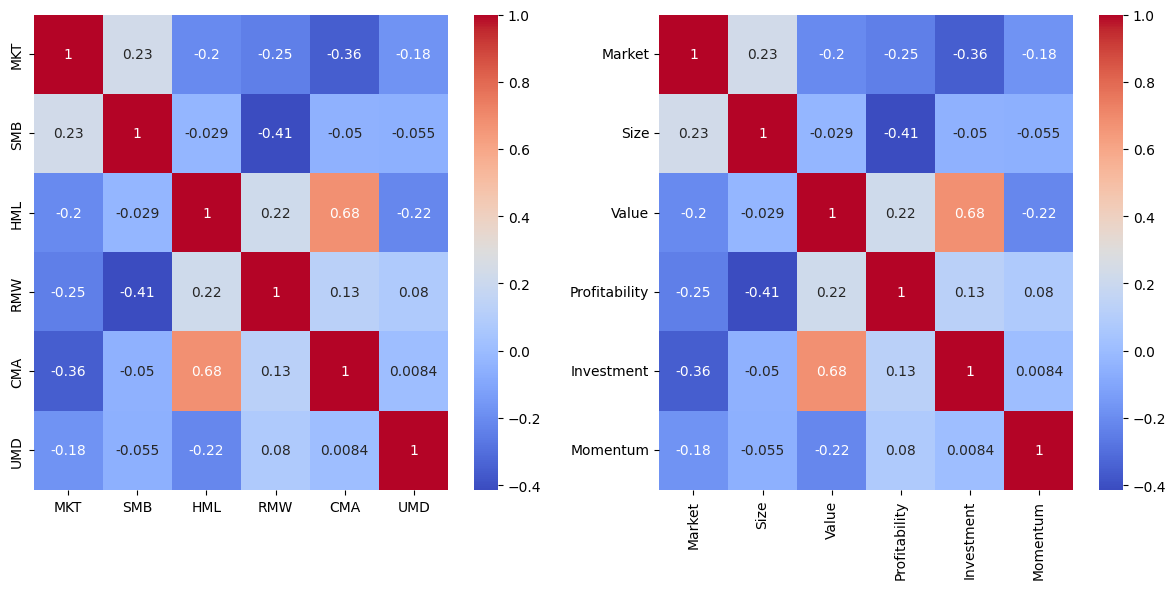

In [70]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df_corr = (df_factors[[c for c in df_factors if "_adj" not in c]]
            # .rename(columns=ticker_mapping)
        .corr()
        )
sns.heatmap(df_corr, annot=True, cmap="coolwarm")

plt.subplot(1, 2, 2)
df_corr = (df_factors[[c for c in df_factors if "_adj" not in c]]
            .rename(columns=ticker_mapping)
        .corr()
        )
sns.heatmap(df_corr, annot=True, cmap="coolwarm")
plt.tight_layout()

The construction keeps most of the correlations small except for HML and CMA which has a high correlation, this is likely the 
reason Fama and French say that HML is somewhat redundant. I would agree that that it is redundent


4. Report the tangency weights for a portfolio of these 6 factors.
* Which factors seem most important? And Least?
* Are the factors with low mean returns still useful?
* Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

What do you conclude about the importance or unimportance of these styles?

In [71]:
def tangent_portfolio(df_returns, flip_weights=False, annual_factor=12):
    def compute_stats(weights, mu_hat, sigma_hat, annual_factor=12):
        p_return = weights.T @ mu_hat * annual_factor
        p_vol = np.sqrt(weights.T @ sigma_hat @ weights) * np.sqrt(annual_factor)
        return p_vol, p_return
    
    mu_hat = df_returns.mean().values
    sigma_hat = df_returns.cov().values
    
    sigma_inv = np.linalg.inv(sigma_hat)
    weights = sigma_inv @ mu_hat
    weights = weights / np.sum(weights)
    
    t_vol, t_return = compute_stats(weights, mu_hat, sigma_hat, annual_factor=annual_factor)
    if t_return < 0 and flip_weights:
        weights *= -1
        t_vol, t_return = compute_stats(weights, mu_hat, sigma_hat, annual_factor=annual_factor)
    return [t_vol, t_return, weights]

# Tangent weights
_, _, t_weights = tangent_portfolio(df_factors) 
df_weights = pd.DataFrame(t_weights, index=df_factors.columns, columns=["Tangent Weights"])

# without RMW,CMA)
factors =["MKT", "SMB", "HML", "UMD"]
col_name = 'tangent (without RMW,CMA)'
_, _, t_weights = tangent_portfolio(df_factors[["MKT", "SMB", "HML", "UMD"]])
df_weights[col_name] = 0
for f in factors:
    df_weights.loc[f, col_name] = t_weights[factors.index(f)]
display(df_weights)

C:\Users\Majes\AppData\Local\Temp\ipykernel_10052\3849253364.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3655293588590313' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_weights.loc[f, col_name] = t_weights[factors.index(f)]


,Tangent Weights,"tangent (without RMW,CMA)"
MKT,0.209760,0.365529
SMB,0.077337,-0.032422
HML,-0.042142,0.356199
RMW,0.313263,0.000000
CMA,0.338982,0.000000
UMD,0.102798,0.310694


This suggests that the market, profitability and CMA are the most useful. 

Without RMW and CMA, market is given more weight and HML, UMD are given a large amount of weight.

This suggests that the removed factors had some significance in the original construction

***

# 3. Testing Modern LPMs

Consider the following factor models:
* CAPM: MKT
* Fama-French 3F: MKT, SMB, HML
* Fama-French 5F: MKT, SMB, HML, RMW, CMA
* AQR: MKT, HML, RMW, UMD

We are not saying this is “the” AQR model, but it is a good illustration of their most publicized factors: value, momentum, and more recently, profitability.

For instance, for the AQR model is...

![](../refs/LFP-4-factors.png)

We will test these models with the time-series regressions. Namely, for each asset i, estimate the following regression to test the AQR model:

![](../refs/LFD-4-factors.png)

Data
* PORTFOLIOS: Monthly excess return data on 49 equity portfolios sorted by their industry. Denote these as $\tilde{r}^i$ , for $n = 1, . . . , 49.$

* You do NOT need the risk-free rate data. It is provided only for completeness. The other two tabs are already in terms of excess returns.

In [72]:
df_portfolios = dfs_raw['portfolios (excess returns)'].set_index("Date")

display(df_portfolios.tail())

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-30,-0.0629,0.0018,-0.0234,-0.0244,0.0199,-0.0368,-0.0999,-0.0632,-0.0205,-0.0686,...,-0.0352,-0.0842,-0.0639,-0.0554,-0.0279,-0.0437,-0.0455,-0.1186,-0.0502,-0.0284
2024-05-31,0.0383,-0.0188,0.0159,-0.0224,0.0598,0.0017,0.0931,0.1255,-0.0024,0.0447,...,0.0350,-0.0008,-0.0029,0.0322,-0.0393,0.0251,0.0324,0.0427,0.0428,0.0348
2024-06-30,-0.0354,-0.0409,-0.0056,-0.0346,0.0062,-0.0406,0.0394,0.0075,-0.0053,-0.1286,...,-0.0877,0.0259,-0.0325,0.0468,0.0019,-0.0103,-0.0065,-0.0128,0.0005,-0.0170
2024-07-31,0.0466,0.0361,0.0312,0.0259,0.1124,0.0806,-0.0441,0.0270,-0.0152,-0.0281,...,0.1134,-0.0025,0.0599,-0.0058,-0.0311,0.0701,0.0799,0.1894,0.0628,0.0545
2024-08-31,0.0186,0.0461,0.0490,0.0040,0.0748,-0.0240,0.0550,0.0121,0.0582,0.0530,...,0.0076,0.0196,-0.0169,0.0027,0.0499,0.0172,0.0385,0.0008,0.0050,0.0579


1. Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)
* For each regression, report the estimated α and r-squared.
* Calculate the mean-absolute-error of the estimated alphas.
* If the pricing model worked, should these alpha estimates be large or small? Why?
* Based on your MAE stat, does this seem to support the pricing model or not?


In [73]:
def factor_model(df, y_var, x_vars, intercept=True):
    if not isinstance(x_vars, list):
        x_vars = [x_vars]
    # Run regression
    formula = f"{y_var} ~ {' + '.join(x_vars)}"
    if not intercept:
        formula = formula + " - 1"
    model = smf.ols(formula=formula, data=df)
    results = model.fit()
    summary = results.summary()

    return model, results

def run_factor_model(df_returns, df_factors, display_info=True, annual_scale=1):
    # merge data
    df_reg = pd.merge(df_returns,
                      df_factors,
                        how="left",
                        left_index=True,
                        right_index=True)
    # Clean cols
    col_mapping = {c: c.replace(" ", "_").replace("-", "_") for c in df_reg.columns}
    rev_mapping = {v: k for k, v in col_mapping.items()}
    df_reg.rename(columns=col_mapping, inplace=True)
    factor_cols = [col_mapping[c] for c in df_factors.columns]
    return_cols = [col_mapping[c] for c in df_returns.columns]
    
    # Run Regressions
    data = []
    for c in return_cols:
        _, results = factor_model(df_reg, c, factor_cols)

        mu_return = df_reg[c].mean() * annual_scale
        vol_return = df_reg[c].std() * np.sqrt(annual_scale)

        row_data = {
            "index": c,
            "info_ratio": mu_return / vol_return,
            "intercept": results.params["Intercept"],
            "R-squared": results.rsquared,
        }
        
        for k, v in results.params.items():
            if k == "Intercept":
                row_data[f"{k}"] = v
            else:
                row_data[f"{k}_beta"] = v
        data.append(row_data)
        
    
    df_regressions_info = pd.DataFrame(data).set_index("index")
    
    # Cross regression
    df_cross = pd.DataFrame()
    df_cross["mean_return"] = df_returns.mean(axis=0)
    df_cross.index = [c.replace(" ", "_").replace("-", "_") for c in df_cross.index]
    cross_factor_cols = [c for c in df_regressions_info if "_beta" in c]
    df_cross = pd.merge(df_cross,
                        df_regressions_info,
                        how="left",
                        left_index=True,
                        right_index=True)
    _, results = factor_model(df_cross, "mean_return", cross_factor_cols)
    cross_reg_info = {
        "R-squared": results.rsquared,
        "Residuals": results.resid,
    }
    cross_reg_info.update({k: v for k, v in results.params.items()})
    
    if display_info:
        display(df_regressions_info)

        for k, v in cross_reg_info.items():
            print(f"{k}: {v:.4f}")
        
    return df_regressions_info, cross_reg_info

# * CAPM: MKT
# * Fama-French 3F: MKT, SMB, HML
# * Fama-French 5F: MKT, SMB, HML, RMW, CMA
# * AQR: MKT, HML, RMW, UMD
factor_models = {
    "CAPM": {"factors": ["MKT"]},
    "Fama-French 3F": {"factors": ["MKT", "SMB", "HML"]},
    "Fama-French 5F": {"factors": ["MKT", "SMB", "HML", "RMW", "CMA"]},
    "AQR": {"factors": ["MKT", "HML", "RMW", "UMD"]},
}
for k, v in factor_models.items():
    df_regressions_info, cross_reg_info = run_factor_model(df_portfolios, 
                                                           df_factors[factor_models[k]["factors"]],
                                                           display_info = False)
    factor_models[k]["reg_info"] = df_regressions_info
    factor_models[k]["cross_reg_info"] = cross_reg_info

In [74]:
display(factor_models["AQR"]["reg_info"][["Intercept", "R-squared"]])

print("Mean abs intercepts:", factor_models["AQR"]["reg_info"]["Intercept"].abs().mean())

,Intercept,R-squared
index,,
Agric,0.000643,0.339175
Food_,0.000579,0.464221
Soda_,0.001436,0.308354
Beer_,0.001422,0.420762
Smoke,0.002942,0.273489
Toys_,-0.003111,0.508340
Fun__,0.002542,0.616501
Books,-0.002452,0.686774
Hshld,-0.000674,0.558410


Mean abs intercepts: 0.0019160515816456622


The pricing models assume that alpha is 0, so if the maodels worked the abs mean should be close to 0.

Based on these results alone the AQR model seems to be a good fit.


2. Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model.
   * Report the MAE statistic for each of these models and compare it with the AQR Model MAE.
   * Which model fits best?
   


In [75]:
for k, v in factor_models.items():
    print(f'Mean abs intercept for {k}: {factor_models[k]["reg_info"]["Intercept"].abs().mean():.4f}')

Mean abs intercept for CAPM: 0.0017
Mean abs intercept for Fama-French 3F: 0.0020
Mean abs intercept for Fama-French 5F: 0.0026
Mean abs intercept for AQR: 0.0019


From the MAE alone, all models look to be a good fit.

3. Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

The MKT factor seems important for pricing, it is in all models so no one even considered dropping that.t_weights

Its very hard to determine if Fama and French should include the Momentum factor. Based on the MAE alone, the AQR portfolio doesnt have strong evidence that says to include it.

4. This does not matter for pricing, but report the average (across $n$ estimations) of the time-series regression r-squared statistics.
   * Do this for each of the three models you tested.
   * Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?


In [76]:
for k, v in factor_models.items():
    print(f'Mean R-Squared for {k}: {factor_models[k]["reg_info"]["R-squared"].abs().mean():.4f}')

Mean R-Squared for CAPM: 0.5261
Mean R-Squared for Fama-French 3F: 0.5715
Mean R-Squared for Fama-French 5F: 0.5960
Mean R-Squared for AQR: 0.5749


These model's R-Squared are okay, so the factors may not give good linear factor decomps.


5. We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.
* Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?4
* Report the MAE of the cross-sectional regression residuals for each of the four models. How do they compare to the MAE of the time-series alphas?

In [ ]:
for k, v in factor_models.items():
    
    
    print(f'Mean Beta (Risk Premia) for {k}: {factor_models[k]["reg_info"]["MKT_beta"].mean():.4f}')

Mean Beta (Risk Premia) for CAPM: 1.0132
Mean Beta (Risk Premia) for Fama-French 3F: 1.0138
Mean Beta (Risk Premia) for Fama-French 5F: 1.0435
Mean Beta (Risk Premia) for AQR: 1.0428


In [83]:
df_cross_reg_info = {k: v["cross_reg_info"] for k, v in factor_models.items()}
for k, _ in df_cross_reg_info.items():
    df_cross_reg_info[k]["MAE Residuals"] = df_cross_reg_info[k]["Residuals"].abs().mean()
df_cross_reg_info = pd.DataFrame(df_cross_reg_info)
df_cross_reg_info.drop("Residuals", inplace=True)

display(df_cross_reg_info)

,CAPM,Fama-French 3F,Fama-French 5F,AQR
R-squared,0.005471,0.370989,0.412609,0.211866
Intercept,0.007115,0.005187,0.004427,0.005783
MKT_beta,0.000514,0.003331,0.003904,0.001931
MAE Residuals,0.001271,0.000989,0.000961,0.001137
SMB_beta,NaN,-0.003604,-0.003866,NaN
HML_beta,NaN,-0.001637,-0.002228,-0.00271
RMW_beta,NaN,NaN,0.002021,0.001897
CMA_beta,NaN,NaN,-0.001811,NaN
UMD_beta,NaN,NaN,NaN,0.000892


In [85]:
df_cross_reg_info.loc["MKT_beta"]

CAPM              0.000514
Fama-French 3F    0.003331
Fama-French 5F    0.003904
AQR               0.001931
Name: MKT_beta, dtype: object

The risk premia in the cross sectional regression are higher then in the time series regression. For CAPM its about twice as high, everything else its on the order of about 10-20.

The MAE in the cross sectional regression are lower then in the time series regression. For CAPM its a little lower, everything else its on the order of about 10-20 times lower.

todo double check what risk premia and MAE are

In [79]:
# plot 

***